# Tutorial: Reduction and Export

Adapted from "Analysis Workflow: Reduction and Export" in the Fermi GBM Data Tools documentation.

GBM was designed with high temporal and spectral resolution primarily to study GRB spectra and spectral evolution throughout a GRB. So, ideally, we would like to reduce the data and model the background so that we can get at the thing we’re really interested in: the source spectrum. The following workflow will show you how you can do this and export the relevant data.

In this tutorial, we will go through an example of how to use the Fermi Gamma-Ray Tools (GDT) toolkit as well as the core GDT toolkit to plot a lightcurve, complete a background fit, and write and export our results using data from the Fermi Gamma-ray Burst Monitor.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import gdt.missions.fermi 
import gdt.core 

To start, we need to be able to download and read in some data. For this example, we will be using TTE data. We can download TTE files with the `TriggerFtp` class from the GDT Fermi toolkit, then read the files with the `GbmTte` class from the same toolkit. Additionally, because we’re using TTE, we’ll need a binning algorithm. We can rebin our data using the `bin_by_time` class from the GDT Core toolkit, binning it to a 1.024 second resolution and using the 0.0 second trigger time as our reference time in this example. Since we're using TTE, we will also need some response files; luckily, response files are already generated for us if our GRB was triggered onboard GBM. We will use event **090131090** as our example event for the rest of this tutorial.

In [56]:
from gdt.missions.fermi.gbm.finders import TriggerFtp
from gdt.missions.fermi.gbm.tte import GbmTte
from gdt.core import data_path
from gdt.core.binning.unbinned import bin_by_time

# initialize trigger finder to pull data from event 090131090
tte_finder = TriggerFtp('090131090')

# download and open a tte file associated with the n9 detector
tte_finder.get_tte(download_dir=data_path.joinpath('090131090'), dets=['n9'])
tte = GbmTte.open(data_path.joinpath('090131090/glg_tte_n9_bn090131090_v01.fit'))

# bin to 1.024 second resolution
phaii = tte.to_phaii(bin_by_time, 1.024, time_ref=0.0)

Output()

Of course we’ll want to visualize what we’re doing, so we will need the `Lightcurve` and `Spectrum` classes from the GDT Core toolkit. Before we can plot, however, we will need to set the energy range we’re interested in. Generally, for the NaI detectors, you don’t want to go below 8 keV. Yes, GBM data goes below that, but the response is poorly calibrated below 8 keV. You also don’t want to include the overflow channel, so going up to ~900 keV should be sufficient. After that, we can plot our first lightcurve.

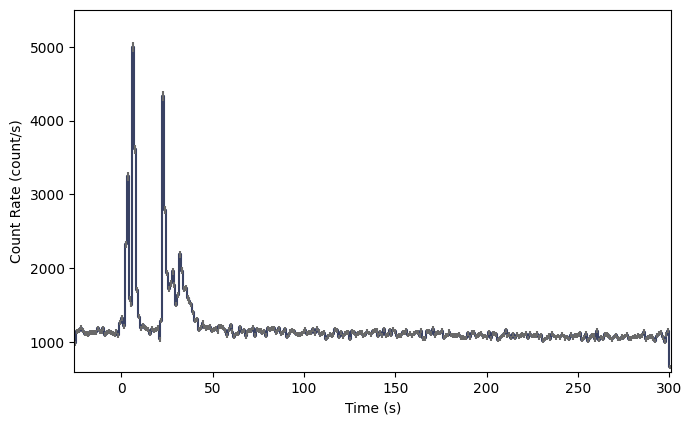

In [57]:
from gdt.core.plot.lightcurve import Lightcurve
from gdt.core.plot.spectrum import Spectrum

# selected energy range in keV
erange = (8.0, 900.0)

# generate and plot lightcurve
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)

Nice looking lightcurve! Next, we’ll want to define regions outside the obvious source region to identify as background. The TTE data early in the mission unfortunately didn’t have very much pre-trigger background, but we’ll try our best. We want two background intervals, one before and one after the source. The idea length of a background range is about two times the length of the source range on either side (so four times the source range, total). For this burst, there isn't enough data before the burst to get our ideal length of time for the background, but there is more than enough data after the burst. 

In [59]:
# select background time intervals before and after the source range
bkgd_times = [(-20.0, -5.0), (75.0, 200.0)]

The background module is in `gdt.core.background`, and similar to the binning algorithms, background modeling algorithms can be divded between binned and unbinned data. TTE data is temporally unbinned, but for simplicitly let’s use a polynomial algorithm for pre-binned data. For this, we can first use the `BackgroundFitter` class to initialize our background fitter with our previously binned data and the `from_phaii()` method. If we were using an unbinned algorithm for the backfitter, we would call `from_tte()` and give it a TTE object instead of a PHAII object. We can then use the `Polynomial` class to complete a polynomial background fit of whatever degree polynomial we want. Typically, it is better to use lower order polynomials to fit the background.

In [60]:
# the background fitter interface
from gdt.core.background.fitter import BackgroundFitter

# our fitting algorithm
from gdt.core.background.binned import Polynomial

# we initialize our background fitter with the phaii object, the algorithm, and the time ranges to fit.
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)

# once initialized, run the fit - in this case, we use a fit the background as a 1st degree polynomial
backfitter.fit(order=1)

Ok, the fit is done, but how do we know if it is a good fit? You can return the fit statistic and degrees-of-freedom (DoF) for each energy channel fit using the `statistic` and `dof` attributes, and try to figure out if it’s a good fit based on that. A statistic divided by DoF that is closer to one often indicates a better fit. Note that this is not always the best way to determine if the fit is good, but it will work for our current example. 

In [61]:
# return an array of the fit statistic over the degrees of freedom
backfitter.statistic/backfitter.dof

array([1.05253464, 0.97225381, 0.91227241, 0.98050048, 0.84681665,
       1.0109339 , 0.83987198, 0.99393676, 0.93546538, 0.97676709,
       1.06159651, 1.13014594, 1.02241299, 0.87300405, 0.93111584,
       0.77749972, 0.88585415, 1.24709709, 1.00078239, 1.18972735,
       1.08504497, 0.86004   , 1.09627527, 1.26029689, 1.02805267,
       1.09511262, 1.09453753, 0.84877554, 1.03829697, 1.18797705,
       1.17876657, 1.0435771 , 0.87277942, 1.1235214 , 0.75154049,
       1.16525405, 0.96174605, 0.86952962, 1.05345248, 1.06671789,
       0.98715977, 0.87106808, 0.81729816, 1.01830519, 0.96619755,
       0.96130275, 1.26006097, 1.10956129, 0.7465444 , 1.14112326,
       1.17921618, 0.99306683, 0.94085532, 0.75801103, 0.93522882,
       0.93297998, 1.34048725, 0.97457337, 0.92851687, 1.13544663,
       1.03582596, 0.86974828, 0.95736557, 0.90115499, 0.97121474,
       0.99067311, 1.03314964, 1.05197093, 0.67085108, 0.86989996,
       1.13958071, 0.79637932, 0.83125611, 0.96961894, 0.70648

It might be difficult to get useful information from just an array, but we can easily plot our fit statistic over our DoF an make a nice graph. Typically, if the plot is relatively flat and close to one, it can indicate a good fit. 

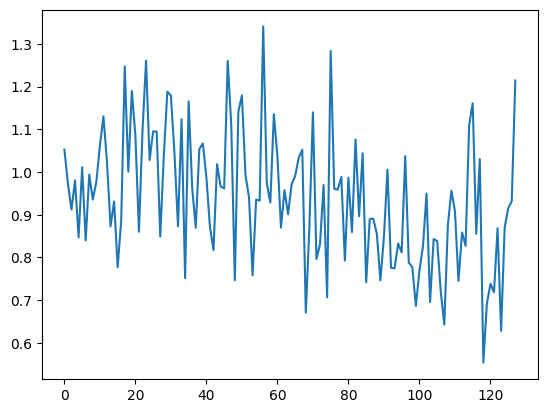

In [62]:
# plot the graph of the fit statistic over the degrees of freedom
plt.plot(backfitter.statistic/backfitter.dof)
plt.show()

Now, let's plot our background model itself. When plotting the background model, it’s a good idea to plot it not just during the background segments you fit, but also during the source interval. This is important because you want to see how well the background is modeled during the source interval. This means that the model needs to be interpolated over the source interval. For simplicity, and to make the background look smooth, we’ll go ahead and interpolate across every time bin in the lightcurve using the `interpolate_bins()` method.

In [63]:
# interpolate the background fitter across every time bin in the lightcurve
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
type(bkgd)

gdt.core.background.primitives.BackgroundRates

So what is `bkgd`? It’s similar to the same data structure that contains the PHAII data: a 2D Time-Energy histogram, but instead of containing observed counts, it contains the modeled background rates for each time bin and energy channel. So if we want to plot the background model on our lightcurve, we need to integrate over energy using the `integrate_energy()` method. Reminder: we don’t want to integrate over all energy channels, only the ones we set in our selected energy range. Now, it's time to plot:

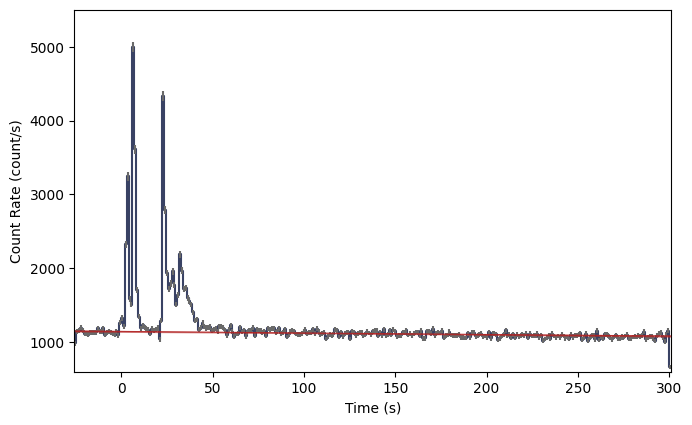

In [64]:
# integrate the background over energy to get data we can plot on a lightcurve
lc_bkgd = bkgd.integrate_energy(*erange)

# plot a lightcurve with our background fit included
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)

And look at that! The red line shows our background model interpolated at each lightcurve bin. If you find your fit to be unacceptable, you can adjust the background ranges or try refitting with a different polynomial order, like so:

In [65]:
# complete a different background fit, this time as a 2nd order polynomial
backfitter.fit(order=2)

We are currently viewing the full time-extent of the data in the file, but if we want to identify a particular time interval for analysis, it’s kind of hard when we’re zoomed out so far. So, you should zoom in appropriately by setting new x-limits.

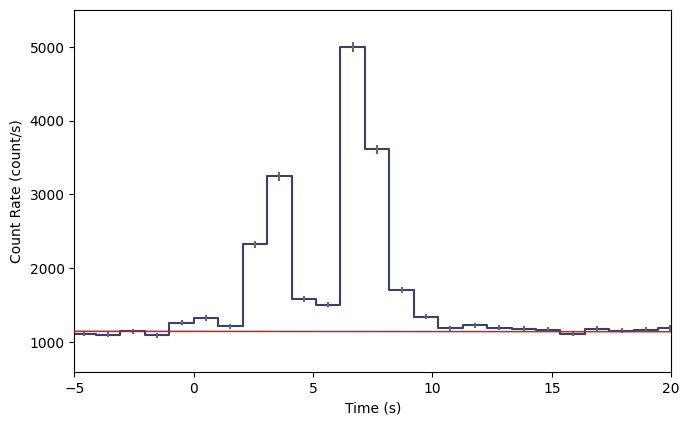

In [66]:
# plot the lightcurve with the data and the background fit
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)

# zoom in to 5 seconds before to 20 seconds after the trigger time
view_range = (-5.0, 20.0)
lcplot.xlim = view_range

Now, we need to define a time interval of interest. It could be a single bin, or it could be multiple bins. Let’s select the brightest two bins in this view.

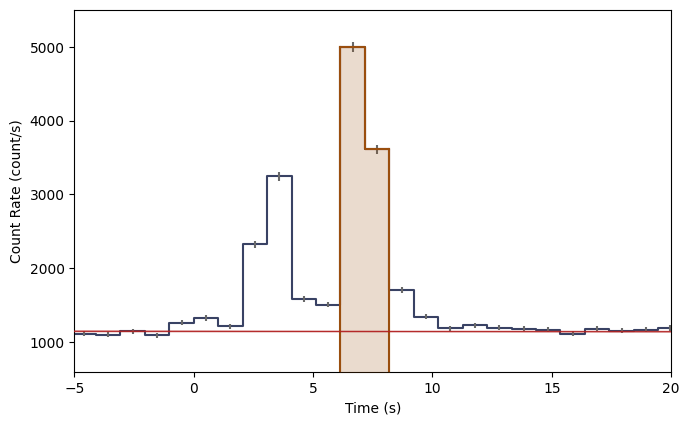

In [69]:
# plot the lightcurve with the data and the background fit
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)

# our lightcurve source selection
src_time = (7.0, 8.0)

# convert the source selection to a lightcurve and add it to our plot
src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)
lcplot.add_selection(src_lc)

# zoom in to the view range selected above
lcplot.xlim = view_range

The orange shading indicates the time bins you’ve selected as source signal. You can also make a plot of the count spectrum during the selection to see what the background model looks like in comparison to the data using the `Spectrum` class that we imported earlier.

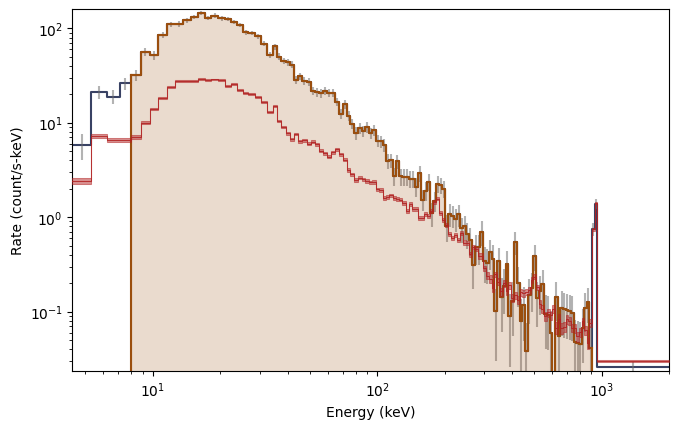

In [70]:
# the observed count spectrum during the source selection
spec_data = phaii.to_spectrum(time_range=src_time)

# the background model integrated over the source selection time
spec_bkgd = bkgd.integrate_time(*src_time)

# the energy range selection that was made
spec_selection = phaii.to_spectrum(time_range=src_time, energy_range=erange)

# plot a count spectrum with the data, background fit, and energy range selection
specplot = Spectrum(data=spec_data, background=spec_bkgd)
specplot.add_selection(spec_selection)

And there you have it! The background model, integrated over the source window, as a function of energy is red, while the orange shaded region indicates the part of the spectrum you’re interested in.

If we are satisifed with everything we’ve done, it’s now time to export our selections. For example, let's export our data as PHA and BAK files. First we need to create PHA and BAK objects, which we can do by using the `to_pha()` and `to_bak()` methods.

In [71]:
# the single-spectrum PHA object over our source time interval and energy range
pha = phaii.to_pha(time_ranges=src_time, energy_range=erange)

# the background spectrum BAK object over our source time interval
bak = bkgd.to_bak(time_range=src_time)
type(pha), type(bak)

(gdt.core.pha.Pha, gdt.core.pha.Bak)

So now you have a PHA and BAK object which can be easily written as fully-formed FITS files using the `.write()` methods:

In [77]:
# write the PHA object as a .pha file
pha.write('./', filename='my_first_custom.pha', overwrite=True)

# write the BAK object as a .bak file
bak.write(directory='./',filename='my_first_custom.bak', overwrite=True)

KeyError: "Keyword 'TZERO1' not found."

You can omit the filename keywords if the default naming convention is good enough for you (although beware of naming conflicts if you are writing multiple files from one event).

Now there is one thing missing; we forgot about the response file! You can’t do any spectral fitting without the response. Let's download and open a response file for our TTE data using the `TriggerFtp` class from earlier, as well as the new `GbmRsp2` class.

In [73]:
from gdt.missions.fermi.gbm.response import GbmRsp2

# initialize the finder to pull from event 090131090
rsp_finder = TriggerFtp('090131090')

# download and open cspec rsp2 data associated with the n9 detector
rsp_finder.get_rsp2(download_dir=data_path.joinpath('090131090'), dets=['n9'], ctime=False)
rsp = GbmRsp2.open(data_path.joinpath('090131090/glg_cspec_n9_bn090131090_v00.rsp2'))

Output()

This is an RSP2 file, meaning that it is a time sequence of DRMs. We want to choose the DRM that is most appropriate for our time selection. We have a couple of options: we could simply return the DRM that is closest to our interval of interest, or we can interpolate the time series of DRMs to provide a response at the time of our interval (more specifically at the center of our time interval).

In [74]:
# the drm that is nearest to our time of interest
nearest_drm = rsp.extract_drm(atime=pha.tcent)

# the interpolated drm
interp_drm = rsp.interpolate(pha.tcent)

Choose one, and you can write it to a file just like the PHA and BAK.

In [75]:
# write the interpolated drm from the rsp2 file to a new rsp file
interp_drm.write('./', filename='my_first_custom.rsp', overwrite=True)

We’re done! You have successfully exported your source selection, background model, and an appropriate detector response. Looking back, it may seem like we’ve done a lot, but most of the commands we issued were for the sake of plotting! Once you’re more familiar with the workflow, you don’t have to make quite so many plots along the way.

Congrats, you've just completed the lesson on reduction and export!